### This notebook is dedicated to classifying trajectories

In [2]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import types
import time
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter


ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run Lesion_Size.ipynb
# %run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

param={
    'treadmillRange':(0,90),
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

---

**initial position analysis**

In [ ]:
def initial_pos(root, profile, animalList, SessionRange, trdBins):
    def et_and_initial_pos(data):
        
        et     =data.entranceTime
        initPos=np.array([data.position[i][data.startFrame[i]] for i in data.position])
        gt     =np.nanmedian(data.goalTime)

        if len(et)==len(initPos):
            return et,initPos,gt
        else:
            return None,None,None
    
    PerfParam=[et_and_initial_pos]
    initialPos=dict()
    countN=0
    for animal in  animalList:
        sessions=batch_get_session_list(root,[animal],profile=profile)['Sessions']
        data=data_fetch(root, animal=animal, profile=profile,
                        PerfParam= PerfParam,
                        NbSession=100)[PerfParam[0].__name__]
        
        data=data[SessionRange[0]:SessionRange[1]]
        initialPos[animal]=[]
        for et,pos,gt in data:
            if et is None:
                countN+=1
                continue
            initialPos[animal].extend(list(pos[et<=16]))
        
        initialPos[animal]=np.array(initialPos[animal])
    
    logging.warning(f'{countN} sessions were removed, entranceTime != position')
    
    return initialPos
    
def probablity_initial_pos(root,profile,animalList, SessionRange, trdBins=range(0,91,1), TH=30):
        
    initialPos= initial_pos(root, profile, animalList, SessionRange, trdBins)
    
    X=np.array(trdBins[1:])-trdBins.step/2
    initPosTH=[]

    for animal in animalList:
        data=initialPos[animal][~np.isnan(initialPos[animal])]
        pdf,_=np.histogram(data, trdBins, density=True)
        cumu=np.cumsum(pdf)
        
        assert len(X)==len(cumu), 'problemo!'
        y=cumu[X>=TH][0]
        initPosTH.append(y)
        
    return np.array(initPosTH)

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'Control'
                  }
    animalList1=batch_get_animal_list(root,profile)
#     animalList=animalList[10:12]

    SessionRange=[20,30]
    
    ctrlInit=probablity_initial_pos(root,profile,animalList1, SessionRange)
    

In [ ]:
if "__file__" not in dir():
    AnimalProfile={'Type':'Good',
#          'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    animalList2=batch_get_animal_list(root,AnimalProfile)
    
    SessionRange=[20,30]
    
    LesionInit=probablity_initial_pos(root,AnimalProfile,animalList2, SessionRange)

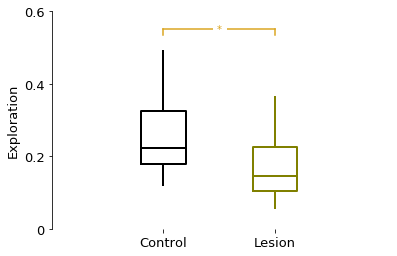

In [295]:
if "__file__" not in dir():
    c=ctrlInit[~np.isnan(ctrlInit)]
    l=LesionInit[~np.isnan(LesionInit)]
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    for i,(data,color) in enumerate(zip((1-c,1-l),('k','olive'))):
        ax.boxplot(x=data,whis=[5,95],
                  positions=[i], widths=.4,
                  showcaps=False, showfliers=False,
                  medianprops={'color':color,'linewidth':2},
                   boxprops={'color':color,'linewidth':2},
                   whiskerprops={'color':color,'linewidth':2},
                  zorder=1)


    test=TwoTailPermTest(group1=np.array(c), group2=np.array(l), nIterations=10000)
    s='*' if test.significantDiff[0] else 'n.s.'
    test.plotSigPair(ax,y=.55,x=(0,1), s=s, color='goldenrod',lw=1.5)

    
    ax.set_xlim([-1,2])
    ax.set_ylabel('Exploration',fontdict=font)
    ax.set_xticks([0,1])
    ax.set_yticks([0,.2,.4,.6])
    ax.set_xticklabels(['Control','Lesion'],fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/earlyBox.pdf')

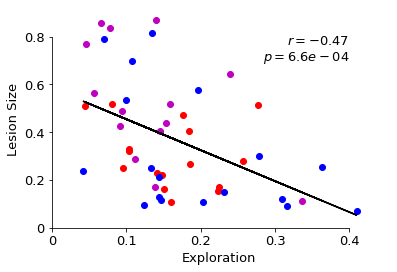

In [296]:
if "__file__" not in dir():
    lesionSize=[]
    lesionExp=[]
    goodAnimal=[]
    for i,animal in enumerate(animalList2):
        if np.isnan(LesionInit[i]):
            continue
        try:
            f=HistologyExcel('/NAS02',animal)
            tmp=f.lesion_size()
        except:
            logging.warning(f'animal with excel problem: {animal}')
            continue
        lesionSize.append(tmp)
        lesionExp.append(1-LesionInit[i])
        goodAnimal.append(animal)
        
    
    lesionSize=np.array(lesionSize)
    lesionExp=np.array(lesionExp)

    lesionSize=lesionSize[lesionExp<.45]
    lesionExp=lesionExp[lesionExp<.45]
    
    color={'control':'k',
       'ds':'m',
       'dms':'b',
       'dls':'r'
       }
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    for animal,exp,size in zip(goodAnimal,lesionExp,lesionSize):
        _,lesion=lesion_type(root, animal)
        c=color[lesion.casefold()]
        ax.plot(exp,size,color=c,marker='o')
    
    r,p=scipy.stats.pearsonr(lesionExp,lesionSize)
    P = np.poly1d(np.polyfit(lesionExp, lesionSize, 1))
    ax.plot(lesionExp,P(lesionExp),'k')
    
    ax.set_xlim([0,.45])
    ax.set_xlabel('Exploration',fontdict=font)
    ax.set_ylabel('Lesion Size',fontdict=font)
    ax.set_xticklabels(ax.get_xticks(),fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,.1,.2,.3,.4])
    ax.set_yticks([0,.2,.4,.6,.8])
    ax.spines['bottom'].set_bounds(0,.4)
    ax.spines['left'].set_bounds(0,.8)
    
    s='$r=$'+'$%+.2f$'%(r)+'\n'+'$p=$'+'$%.1e$'%(p)
    ax.text(x=.4, y=.8, s=s, ha='right', va='top', fontsize=13)

#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/early.pdf')

**initial position analysis for late lesion**

In [6]:
def session_initial_pos(root,profile,animal, SessionRange: slice, trdBins=range(0,91,1), TH=30):
    def et_and_initial_pos(data):
        et     =data.entranceTime
        initPos=np.array([data.position[i][data.startFrame[i]] for i in data.position])
        gt     =np.nanmedian(data.goalTime)

        if len(et)==len(initPos):
            return et,initPos,gt
        else:
            return None,None,None
    
    PerfParam=[et_and_initial_pos]
    initialPos=dict()
    countN=0

    data=data_fetch(root, animal=animal, profile=profile,
                    PerfParam= PerfParam,
                    NbSession=100)[PerfParam[0].__name__]

    data=data[SessionRange]
    initialPos=[]
    for et,pos,gt in data:
        if et is None:
            countN+=1
            continue
        initialPos.extend(list(pos[et<=16]))

    initialPos=np.array(initialPos)
    
    logging.warning(f'{countN} sessions were removed, entranceTime != position')
    
    X=np.array(trdBins[1:])-trdBins.step/2
    data=initialPos[~np.isnan(initialPos)]
    pdf,_=np.histogram(data, trdBins, density=True)
    cumu=np.cumsum(pdf)

    assert len(X)==len(cumu), 'problemo!'
    y=cumu[X>=TH][0]
    initPosTH=y
        
    return initPosTH

In [ ]:
if "__file__" not in dir():
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control','Control-AfterBreak','Control-Late-NoTimeout-BackToTimeout',
                    'Control-NoTimeout-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS',
                    'Late-Lesion_DMS-Sharp','Late-Lesion_DLS-Sharp','Late-Lesion_DS-Sharp'
                   ]
             }
    
    _,sessionDic=event_detect(root,profile1,profile2)

    
    preInit =[]
    postInit=[]
    for animal in sessionDic.keys():
        a=session_initial_pos(root,profile1,animal, SessionRange=slice(-10,None))
        b=session_initial_pos(root,profile2,animal, SessionRange=slice(0,10))
        preInit.append(a)
        postInit.append(b)

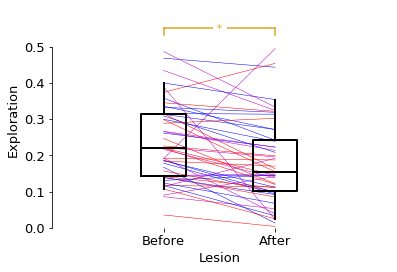

In [24]:
if "__file__" not in dir():
    data=np.array([preInit,postInit]).T
    data=1-data
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)

    #plotting the errorbar
    fig=plt.figure()
    ax=fig.add_subplot(111)
    props={'color':'k','linewidth':2}
    ax.boxplot(x=data,whis=[5,95],
                  positions=[0,1], widths=.4,
                  showcaps=False, showfliers=False,
                  medianprops=props, boxprops=props, whiskerprops=props,
                  zorder=2)

    assert len(sessionDic.keys())==len(data), 'problemo bad!'
    
    color={'control':'k',
           'ds':'m',
           'dms':'b',
           'dls':'r'
           }

    #plotting single animals
    for i,(before,after) in enumerate(data):
        animal=list(sessionDic.keys())[i]
        _,lesion=lesion_type(root, animal)
        c=color[lesion.casefold()]
        ax.plot([0,1],[before,after],lw=.5,alpha=1,zorder=1,color=c)



    ax.set_xlim([-1,2])
    ax.set_ylim([0,.6])
    ax.set_xticks([0,1])
    ax.set_yticks([0,.1,.2,.3,.4,.5])
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.set_xticklabels(['Before','After'],fontdict=font)
    ax.set_xlabel('Lesion',fontdict=font)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(0,.5)
    ax.set_ylabel('Exploration',fontdict=font)
    
    test=TwoTailPermTest(group1=data[:,0], group2=data[:,1], nIterations=10000)
    s='*' if test.significantDiff[0] else 'n.s.'
    test.plotSigPair(ax,y=.55,x=(0,1), s=s, color='goldenrod',lw=1.5)
    
    
#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/late.pdf')

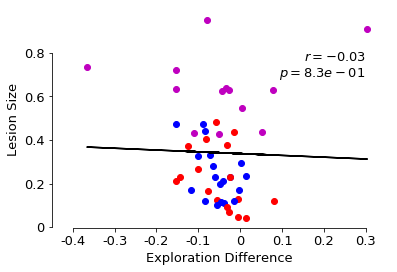

In [30]:
if "__file__" not in dir():
    ratSize=[]
    ratExp=[]
    ratLate=[]
    for i,animal in enumerate(sessionDic.keys()):
        try:
            f=HistologyExcel('/NAS02',animal)
            tmp=f.lesion_size()
        except:
            logging.warning(f'animal with excel problem: {animal}')
            continue
        ratSize.append(tmp)
        ratExp.append(data[i,1]-data[i,0])
        ratLate.append(animal)
        
    
    ratSize=np.array(ratSize)
    ratExp=np.array(ratExp)

#     lesionSize=lesionSize[lesionExp<.45]
#     lesionExp=lesionExp[lesionExp<.45]
    
    color={'control':'k',
       'ds':'m',
       'dms':'b',
       'dls':'r'
       }
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    for animal,exp,size in zip(ratLate,ratExp,ratSize):
        _,lesion=lesion_type(root, animal)
        c=color[lesion.casefold()]
        ax.plot(exp,size,color=c,marker='o')
    
    r,p=scipy.stats.pearsonr(ratExp,ratSize)
    P = np.poly1d(np.polyfit(ratExp, ratSize, 1))
    ax.plot(ratExp,P(ratExp),'k')
    
    ax.set_xlim([-.45,.35])
    ax.set_xlabel('Exploration Difference',fontdict=font)
    ax.set_ylabel('Lesion Size',fontdict=font)
#     ax.set_xticks([0,.1,.2,.3,.4])
#     ax.set_yticks([0,.2,.4,.6,.8])
    ax.set_xticklabels(ax.get_xticks(),fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(-.4,.3)
    ax.spines['left'].set_bounds(0,.8)
    
    s='$r=$'+'$%+.2f$'%(r)+'\n'+'$p=$'+'$%.1e$'%(p)
    ax.text(x=.3, y=.8, s=s, ha='right', va='top', fontsize=13)

#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/lateCorrelate.pdf')

# Speed of trials initiated in the back

In [90]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }
    
    NbSession=slice(-5,None)
    _,sessionDic=event_detect(root,profile1,profile2)

In [91]:
def back_initiating_trial_speed(data, back=65):
    AllSpeed=forwardRunningSpeed(data).compute()
    speed=[]
    for i,vigor in AllSpeed.items():
        if data.position[i][25] < back:
            continue
        
        speed.append(vigor)
    
    return np.nanmean(speed)
def front_initiating_trial_speed(data, front=25):
    AllSpeed=forwardRunningSpeed(data).compute()
    speed=[]
    for i,vigor in AllSpeed.items():
        if data.position[i][25] > front:
            continue
        
        speed.append(vigor)
    
    return np.nanmean(speed)

In [92]:
data=[]
for animal in sessionDic.keys():
    a=np.mean(list(data_fetch(root,animal,profile2,[front_initiating_trial_speed],NbSession).values()))
    b=np.mean(list(data_fetch(root,animal,profile2,[back_initiating_trial_speed],NbSession).values()))
    
    data.append([a,b])
data=np.array(data)

(-1, 1)

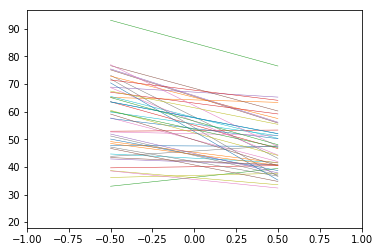

In [93]:
ax=plt.gca()
for before,after in data:
    ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
    
plt.xlim([-1,1])

In [94]:
x=data[:,1]-data[:,0]
x=x[~ np.isnan(x)]

a=bootstrap(x,10000)
np.nanpercentile(a,[1,99])

array([-14.82231405,  -8.23760274])

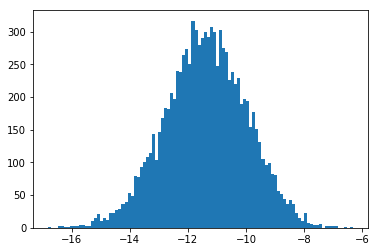

In [95]:
plt.hist(a,100);
plt.show()

In [96]:
scipy.stats.ttest_rel(data[:,0],data[:,1],nan_policy='omit')

Ttest_relResult(statistic=7.875548367519834, pvalue=6.09177097186864e-10)